<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/A_Journey_into_the_Depths_of_Neural_Networks/blob/master/Entering_the_World_of_Multi_Class_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entering the World of Multi Class Classifiers**

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

## **Loading Dataset and Normalization**

In [20]:
if __name__ == "__main__":
    # Load in the data
    cifar10 = tf.keras.datasets.cifar10

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0

    print(X_train.shape)
    print(X_test.shape)

    print(y_train.shape)
    print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## **Flatten and Reshape Images**

In [21]:
if __name__ == "__main__":
    # reshape images from (32, 32, 3) to (3072,)
    X_train = X_train.reshape((X_train.shape[0], -1))  # (50000, 3072)
    X_test = X_test.reshape((X_test.shape[0], -1))     # (10000, 3072)

    y_train, y_test = y_train.flatten(), y_test.flatten() # (50000,  -   10000,)
    print(y_train[:10])

[6 9 9 4 1 1 2 7 8 3]


## **One-Hot Encoding**

In [22]:
y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
# print(y_test.shape)

print(y_train[:10])
# print(y_test[:10])

(50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## **Model**

### **Activation Function : Sigmoid and Relu and Softmax**

In [16]:
class Activation:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(a):
        return a * (1 - a)

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
        return exps / np.sum(exps, axis=1, keepdims=True)

    @staticmethod
    def softmax_derivative(output):
        # The exact derivative of softmax is a Jacobian matrix.
        # However, when used with cross-entropy loss, the gradient simplifies to:
        # ∂L/∂z = y_pred - y_true
        # So this method is typically not needed explicitly during backpropagation.
        pass

## **Neural Network**

### **Dence Layer Class**

In [17]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation='sigmoid'):
        self.w = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.activation_name = activation
        self.z = None
        self.a = None
        self.input = None

    def forward(self, x):
        self.input = x
        self.z = np.dot(x, self.w) + self.b
        if self.activation_name == 'sigmoid':
            self.a = Activation.sigmoid(self.z)
        elif self.activation_name == 'relu':
            self.a = Activation.relu(self.z)
        elif self.activation_name == 'softmax':
            self.a = Activation.softmax(self.z)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_name}")
        return self.a

    def backward(self, da, lr):
        m = self.input.shape[0]

        # Derivative depending on activation function
        if self.activation_name == 'sigmoid':
            dz = da * Activation.sigmoid_derivative(self.a)
        elif self.activation_name == 'relu':
            dz = da * Activation.relu_derivative(self.z)
        elif self.activation_name == 'softmax':
            # With softmax + cross-entropy, da is already (y_pred - y_true)
            dz = da
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_name}")

        # Compute gradients
        dw = np.dot(self.input.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        da_prev = np.dot(dz, self.w.T)

        # Update weights
        self.w -= lr * dw
        self.b -= lr * db

        return da_prev

### **Neural Network Class**

In [18]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-8
        if y_true.shape[1] == 1:  # Binary classification
            return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        else:  # Multi-class classification
            return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))

    def backward(self, y_true, y_pred, lr):
        if y_true.shape[1] == 1:  # Binary classification (sigmoid + BCE)
            dz = y_pred - y_true
        else:  # Multi-class classification (softmax + CCE)
            dz = y_pred - y_true  # Gradient for softmax + cross-entropy
        gradient = dz

        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, lr)

    def train(self, X, y, epochs=100, lr=0.01, batch_size=64, verbose=True):
        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = []

            for i in range(0, X.shape[0], batch_size):
                x_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                output = x_batch
                for layer in self.layers:
                    output = layer.forward(output)

                # Compute loss
                loss = self.compute_loss(y_batch, output)
                epoch_loss.append(loss)

                # Backward pass
                self.backward(y_batch, output, lr)

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {np.mean(epoch_loss):.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        if y_pred.shape[1] == 1:  # Binary classification
            return (y_pred >= 0.5).astype(int)
        else:  # Multi-class classification
            return np.argmax(y_pred, axis=1)

## **Main**

In [8]:
if __name__ == "__main__":
    model = NeuralNetwork()
    model.add(DenseLayer(3072, 64, activation='sigmoid'))
    model.add(DenseLayer(64, 10, activation='softmax'))

    model.train(X_train, y_train, epochs=1000, lr=0.05, batch_size=64)
    predictions = model.predict(X_test)

Epoch 0: Loss = 2.1652
Epoch 10: Loss = 1.6128
Epoch 20: Loss = 1.4759
Epoch 30: Loss = 1.3954
Epoch 40: Loss = 1.3365
Epoch 50: Loss = 1.2893
Epoch 60: Loss = 1.2487
Epoch 70: Loss = 1.2155
Epoch 80: Loss = 1.1804
Epoch 90: Loss = 1.1551
Epoch 100: Loss = 1.1302
Epoch 110: Loss = 1.1067
Epoch 120: Loss = 1.0837
Epoch 130: Loss = 1.0647
Epoch 140: Loss = 1.0435
Epoch 150: Loss = 1.0283
Epoch 160: Loss = 1.0102
Epoch 170: Loss = 0.9956
Epoch 180: Loss = 0.9789
Epoch 190: Loss = 0.9637
Epoch 200: Loss = 0.9498
Epoch 210: Loss = 0.9339
Epoch 220: Loss = 0.9217
Epoch 230: Loss = 0.9096
Epoch 240: Loss = 0.8977
Epoch 250: Loss = 0.8866
Epoch 260: Loss = 0.8733
Epoch 270: Loss = 0.8608
Epoch 280: Loss = 0.8512
Epoch 290: Loss = 0.8401
Epoch 300: Loss = 0.8300
Epoch 310: Loss = 0.8177
Epoch 320: Loss = 0.8080
Epoch 330: Loss = 0.7993
Epoch 340: Loss = 0.7880
Epoch 350: Loss = 0.7797
Epoch 360: Loss = 0.7741
Epoch 370: Loss = 0.7645
Epoch 380: Loss = 0.7557
Epoch 390: Loss = 0.7469
Epoch 400: 

## **Calculation and Evaluation**

Confusion Matrix:
 [[325  40  72  76 149  50  29  24 156  79]
 [ 25 474  13  57  26  42  32  22 104 205]
 [ 48  19 235 172 231 131  87  31  14  32]
 [ 10  14  46 406  99 225 116  20  20  44]
 [ 18  15  76 117 487 102  83  59  28  15]
 [  6   8  45 303  84 396  79  36  22  21]
 [  4  12  50 169 133  92 481  18  18  23]
 [ 24  19  34 118 180 151  34 369  16  55]
 [ 52  66  20  62  71  36  17   8 586  82]
 [ 23 141  11  94  34  58  31  37  76 495]]


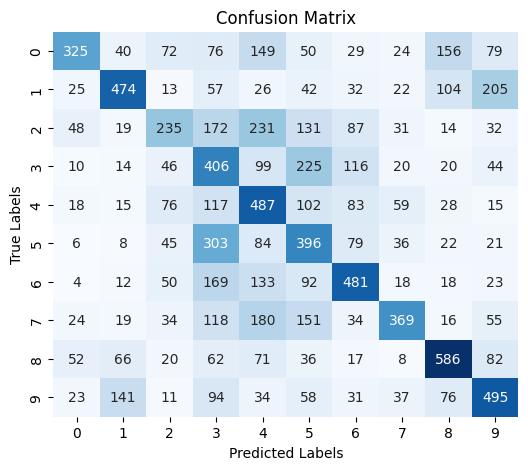

F1 Score (macro): 0.4289378687974864
Accuracy: 0.4254
Precision (macro): 0.4589177003924503
Recall (macro): 0.42539999999999994


In [23]:
if __name__ == "__main__":
    # predictions and y_test are already integer class labels (0 to 9)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # F1 Score (macro for multi-class)
    f1 = f1_score(y_test, predictions, average='macro')
    print("F1 Score (macro):", f1)

    # Optional: Accuracy, Precision, Recall
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions, average='macro')
    rec = recall_score(y_test, predictions, average='macro')

    print("Accuracy:", acc)
    print("Precision (macro):", prec)
    print("Recall (macro):", rec)